## 12.注意力机制

**学习目标**

1. 了解注意力机制、缩放点积注意力、多头注意力和自注意力的概念

2. 了解掩蔽softmax函数实现

3. 了解缩放点积注意力的代码实现

4. 了解多头注意力的代码实现

****

2022 年 11 月，OpenAI 发布了 ChatGPT，迅速在产业界引起巨大波澜，自此，人工智能大模型时代拉开了序幕。ChatGPT 基于 **Transformer 架构**，具有强大的语言生成和理解能力。它能够模拟人类的对话方式，广泛应用于聊天、内容创作、编程辅助等领域。

1、为什么要使用Transformer?

CNN在图像识别领域取得了令人瞩目的成就，如ResNet、YOLO等在图像分类、目标检测领域都非常成功。但是在自然语言处理领域，CNN表现的相当糟糕，以至于完全无法使用CNN来处理自然语言。而传统的RNN、LSTM等模型在处理长序列时表现不佳，原因是它们的记忆能力有限，只能记住最近的输入信息，而远距离的上下文信息则难以捕捉。Transformer模型的出现正好解决了这个问题，它通过自注意力机制解决了长序列建模的问题。

2、什么是注意力机制？

注意力机制（Attention Mechanism）是一种在深度学习中广泛使用的机制。视觉注意力机制是人类大脑的一种天生的能力。当我们看到一幅图片时，先是快速扫过图片，然后锁定需要重点关注的目标区域。比如当我们观察上述图片时，注意力很容易就集中在了人脸、文章标题和文章首句等位置。试想，如果每个局部信息都不放过，那么必然耗费很多精力，不利于人类的生存进化。同样地，在深度学习网络中引入类似的机制，可以简化模型，加速计算。另外，长距离“记忆”能力一直是个大难题，而引入“注意力机制”也能有效缓解这一问题。

在实现上，注意力机制通常涉及计算一个查询（Query）、一组键（Key）和一组值（Value）之间的交互，然后根据这些交互生成加权的输出。

注意力机制的基本思想是，模型能够通过注意力机制来选择性地聚焦于输入序列中的特定部分，从而提高模型的性能和解释性。具体来说，注意力机制可以分为以下几个步骤：

（1）计算注意力权重：模型首先计算输入序列中每个元素与当前上下文的相关性，并将这些相关性作为权重分配给输入序列中的每个元素。

（2）应用注意力权重：模型将注意力权重应用于输入序列，以聚焦于与当前任务最相关的部分。

（3）生成输出：模型根据注意力权重生成输出，其中输出的选择性取决于输入序列中与当前上下文最相关的部分。



注意力机制的引入，为深度学习模型提供了一种强大的工具，以更有效地处理序列数据，特别是在需要考虑全局上下文信息的任务中。

****
下面我们就逐步构建出自注意力和多头注意力模型：

In [1]:
import math
import torch
from torch import nn
from matplotlib import pyplot as plt

1.注意力可视化函数

为了更好的理解注意力机制，我们首先设计一个注意力可视化函数来绘制注意力矩阵。

In [2]:
# 定义一个函数，用于显示热图
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap='Reds'):
    # 获取矩阵的行数和列数
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    # 创建一个图形和一组子图轴
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize, sharex=True, 
                                 sharey=True, squeeze=False)
    
    # 遍历每一行的子图轴和对应的矩阵
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        # print(i, row_axes, row_matrices)
        # 遍历每一行的子图轴和对应的矩阵
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            # print(j, ax, matrix)
            # 在子图轴上显示矩阵的热图
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            # 如果是最后一行，则设置x轴标签
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            # 如果是第一列，则设置y轴标签
            if j == 0:
                ax.set_ylabel(ylabel)
            # 如果提供了标题，则设置子图的标题
            if titles:
                ax.set_title(titles[j])
                
    # 为整个图形添加颜色条
    fig.colorbar(pcm, ax=axes, shrink=0.6)
    # 显示图形
    plt.show()

enumerate(zip(axes, matrices)) 是 Python 中的一种组合用法，用于同时遍历两个列表（或其他可迭代对象），并且还能获取每个元素的索引。

1. zip(axes, matrices) 作用：将两个可迭代对象 axes 和 matrices 配对组合。生成一个包含元组的迭代器，每个元组由 axes 和 matrices 中对应位置的元素组成。

示例1：

如果 axes = ['a1', 'a2']，matrices = [[1, 2], [3, 4]]，那么 zip(axes, matrices) 会生成 [('a1', [1, 2]), ('a2', [3, 4])]。

2. enumerate(...) 作用：为 zip(axes, matrices) 生成的每个元素添加一个索引。生成一个包含元组的迭代器，每个元组由索引和 zip(axes, matrices) 中的元素组成。

示例2：

如果 zip(axes, matrices) 生成 [('a1', [1, 2]), ('a2', [3, 4])]，那么 enumerate(zip(axes, matrices)) 会生成 [(0, ('a1', [1, 2])), (1, ('a2', [3, 4]))]。

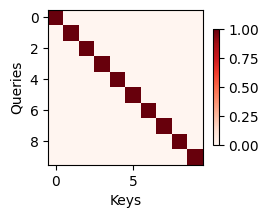

In [3]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

2.缩放点积注意力

缩放点积注意力（Scaled Dot-Product Attention）是 Transformer 模型中的核心机制之一，用于计算输入序列中每个位置的注意力权重。它的公式如下：

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

其中：

- Q：查询矩阵（Query），形状为 (n,dk)，表示 n个查询向量，每个向量的维度为 dk。
- K：键矩阵（Key），形状为 (m,dk)，表示 m个键向量，每个向量的维度为 dk。
- V：值矩阵（Value），形状为 (m,dv)，表示 m个值向量，每个向量的维度为 dv。
- d：键和查询的维度。
- sqrt(d)：缩放因子，用于防止点积结果过大。
- softmax：对每一行进行归一化，得到注意力权重。

下面我们来详细解释该公式：

首先，计算查询矩阵 Q和键矩阵 K的转置 KT的点积。结果是一个形状为 (n,m)的矩阵，表示每个查询向量与每个键向量的相似度。

其次，将点积结果除以sqrt(d)，目的是防止点积结果过大，导致 softmax 函数的梯度消失或爆炸。当 d较大时，点积结果的方差会增大，因此需要通过缩放来平衡。

然后，进行对缩放后的点积矩阵的每一行进行 softmax 归一化，得到注意力权重矩阵。每一行的值表示一个查询向量对所有键向量的注意力权重，且每一行的权重之和为 1。

最后，将注意力权重矩阵与值矩阵 V 相乘，得到最终的输出。计算结果是一个形状为 (n,dv)的矩阵，表示每个查询向量对应的加权值向量。

根据分析可以得知，缩放点积注意力公式的作用是：

1. 计算查询向量与键向量的相似度。
2. 通过 softmax 归一化得到注意力权重。
3. 根据注意力权重对值向量进行加权求和，得到最终输出。

在该公式中，我们使用的softmax通常是一种被称为掩蔽softmax的函数，我们先来实现掩蔽softmax函数：

In [4]:
# 掩蔽softmax函数，用于在softmax操作中屏蔽无效的数据
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作
        X:3D张量
        valid_lens:1D张量, valid_lens.shape == torch.Size([X.shape[0]])
        valid_lens:2D张量, valid_lens.shape == torch.Size([X.shape[0], X.shape[1]])
    """
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    
    else:
        shape = X.shape
        
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)

        X = X.reshape(-1, shape[-1])
        arange_X = torch.arange((X.size(-1)), dtype=torch.float32, device=X.device)
        # 将序列arange_X与valid_len进行比较，生成一个布尔类型的掩码
        mask = arange_X[None, :] < valid_lens[:, None]
        # print(f'MASK:\n{mask} \n X:\n{X}')
        X[~mask] = -1e6
        
        # 对掩蔽后的X应用softmax
        return nn.functional.softmax(X.reshape(shape), dim=-1)

X[~mask]是一种高级索引（advanced indexing）的形式，用于根据布尔掩码 mask 从张量 X 中选择元素。这里的 ~ 操作符表示对 mask 进行按位取反操作，从而选择 mask 中为 False 的位置对应的元素。

In [5]:
# 测试masked_softmax函数
X = torch.rand(3, 2, 6)
valid_lens = torch.tensor([1, 2, 3])

print('\n masked softmax:\n')
print(masked_softmax(X, valid_lens))


 masked softmax:

tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.4526, 0.5474, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3412, 0.6588, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.4026, 0.4131, 0.1843, 0.0000, 0.0000, 0.0000],
         [0.3756, 0.4234, 0.2010, 0.0000, 0.0000, 0.0000]]])


在有了掩蔽softmax函数以后，我们就可以实现缩放点积注意力啦。

In [6]:
class DotProductAttention(nn.Module):
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, queries, keys, values, valid_lens=None):
        # 查询、键和值的维度应相同
        d = queries.shape[-1]
        # 计算查询和键的点积，然后除以d的平方根进行缩放
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        # 应用掩蔽softmax获取注意力权重
        self.attention_weights = masked_softmax(scores, valid_lens)
        # 应用dropout并计算加权值
        return torch.bmm(self.dropout(self.attention_weights), values)

测试缩放点积注意力


 queries keys values:

torch.Size([2, 10, 2])
torch.Size([2, 10, 2])
torch.Size([2, 10, 4])
tensor([[[11.3451, 12.3451, 13.3451, 14.3451],
         [11.4967, 12.4967, 13.4967, 14.4967],
         [ 9.6025, 10.6025, 11.6025, 12.6025],
         [10.0780, 11.0780, 12.0780, 13.0780],
         [14.2400, 15.2400, 16.2400, 17.2400],
         [ 9.9081, 10.9081, 11.9081, 12.9081],
         [12.5453, 13.5453, 14.5453, 15.5453],
         [11.8300, 12.8300, 13.8300, 14.8300],
         [12.2373, 13.2373, 14.2373, 15.2373],
         [11.8355, 12.8355, 13.8355, 14.8355]],

        [[ 4.1968,  5.1968,  6.1968,  7.1968],
         [ 5.2783,  6.2783,  7.2783,  8.2783],
         [ 2.4953,  3.4953,  4.4953,  5.4953],
         [ 4.8445,  5.8445,  6.8445,  7.8445],
         [ 4.2992,  5.2992,  6.2992,  7.2992],
         [ 3.0875,  4.0875,  5.0875,  6.0875],
         [ 3.7612,  4.7612,  5.7612,  6.7612],
         [ 7.5646,  8.5646,  9.5646, 10.5646],
         [ 4.6555,  5.6555,  6.6555,  7.6555],
         [ 5

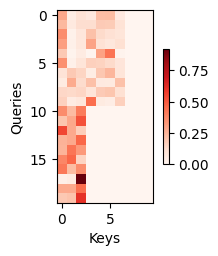

In [24]:
# 初始化查询、键和值的随机数据
queries = torch.normal(0, 1, (2, 10, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)

# 打印查询、键和值的形状
print("\n queries keys values:\n")
print(queries.shape)
print(keys.shape)
print(values.shape)

# 设置有效长度
valid_lens = torch.tensor([7, 3])
# 创建DotProductAttention实例
attention = DotProductAttention(dropout=0.5)
# 将模型设置为评估模式
attention.eval()
# 计算注意力输出
print(attention(queries, keys, values, valid_lens))

# 使用show_heatmaps函数显示注意力权重的热图
show_heatmaps(attention.attention_weights.reshape((1, 1, 20, 10)), xlabel='Keys', ylabel='Queries')

3.多头注意力和自注意力

自注意力是一种机制，用于计算序列中每个元素与其他元素之间的相关性（注意力权重），从而捕捉序列内部的依赖关系。多头注意力是一种多层次的注意力机制，它允许模型在多个不同的表示子空间中并行地学习信息。这可以提高模型捕获不同类型信息的能力。多头注意力是对自注意力的一种扩展，它通过并行运行多个自注意力机制（称为“头”），并将它们的结果拼接或加权组合，从而捕捉更丰富的特征。因此多头注意力的每个头本质上是一个自注意力机制。

（1）用于变换查询、键、值的形状以适应多头注意力的函数

In [25]:
# 用于变换查询、键、值的形状以适应多头注意力
def transpose_qkv(X, num_heads):
    # 将输入X变换为适合多头注意力的形状
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
    X = X.permute(0, 2, 1, 3)
    # 展平前两个维度以进行批处理操作
    return X.reshape(-1, X.shape[2], X.shape[3])

（2）用于变换多头注意力的输出形状的函数

In [26]:
# 用于变换多头注意力的输出形状
def transpose_output(X, num_heads):
    # 将多头输出变换回原始形状
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    
    return X.reshape(X.shape[0], X.shape[1], -1)

（3）多头注意力的实现

In [37]:
# 多头注意力
class MultiHeadAttention(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens, 
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        # 设置多头的数量
        self.num_heads = num_heads
        # 初始化点积注意力模块
        self.attention = DotProductAttention(dropout)
        # 初始化查询、键、值的线性变换层
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        # 初始化输出的线性变换层
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)
        
    def forward(self, queries, keys, values, valid_lens):
        # 将查询、键、值通过各自的线性层，并按照多头的方式进行变换
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)
        print("\n将查询、键、值通过各自的线性层，并按照多头的方式进行变换:")
        print(f'Q.shape = {queries.shape}\nK.shape = {keys.shape}\nV.shape = {values.shape}')
        
        # 如果提供了有效长度，则在多头注意力中应用掩蔽
        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)
        
        # 计算注意力输出
        output = self.attention(queries, keys, values, valid_lens)
        print("\n注意力输出:")
        print(output.shape)
        # 将多头的输出变换回原始形状
        output_concat = transpose_output(output, self.num_heads)
        print("\n将多头的输出变换回原始形状:")
        print(output_concat.shape)
        # 通过输出的线性层
        return self.W_o(output_concat)

（4）多头注意力和自注意力测试

In [38]:
batch_size = 2
num_hiddens = 100
num_heads = 5
num_queries = 4
num_kvpairs = 6  # 键值对数量
valid_lens = torch.tensor([3, 2])

# 实例化多头注意力
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens, num_hiddens, num_heads, 0.5)

attention.eval()
# 创建查询和键值对的随机数据
X = torch.ones(batch_size, num_queries, num_hiddens)
Y = torch.ones(batch_size, num_kvpairs, num_hiddens)
print(f'\nX.shape = {X.shape} \nY.shape = {Y.shape} ')

# 打印多头注意力输出的形状
mul_att_shape = attention(X, Y, Y, valid_lens).shape
self_att_shape = attention(X, X, X, valid_lens).shape
print(f'多头注意力形状：{mul_att_shape}')
print(f'自注意力形状：{self_att_shape}')


X.shape = torch.Size([2, 4, 100]) 
Y.shape = torch.Size([2, 6, 100]) 

将查询、键、值通过各自的线性层，并按照多头的方式进行变换:
Q.shape = torch.Size([10, 4, 20])
K.shape = torch.Size([10, 6, 20])
V.shape = torch.Size([10, 6, 20])

注意力输出:
torch.Size([10, 4, 20])

将多头的输出变换回原始形状:
torch.Size([2, 4, 100])

将查询、键、值通过各自的线性层，并按照多头的方式进行变换:
Q.shape = torch.Size([10, 4, 20])
K.shape = torch.Size([10, 4, 20])
V.shape = torch.Size([10, 4, 20])

注意力输出:
torch.Size([10, 4, 20])

将多头的输出变换回原始形状:
torch.Size([2, 4, 100])
多头注意力形状：torch.Size([2, 4, 100])
自注意力形状：torch.Size([2, 4, 100])
